**First try of training GAN with Adversarial Attacks. SNGAN implementation**

SNGAN references https://github.com/w86763777/pytorch-gan-collections

# Prework

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm import trange
from torch import nn
import random
import time
from IPython.display import clear_output
import torchvision.transforms as T
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import make_grid, save_image
import os
from pytorch_gan_metrics import get_inception_score_and_fid
import wandb

wandb.login()

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  *******


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [64]:
#!g1.1
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def generate_imgs(net_G, device, z_dim=128, size=5000, batch_size=128):
    net_G.eval()
    imgs = []
    with torch.no_grad():
        for start in trange(0, size, batch_size,
                            desc='Evaluating', ncols=0, leave=False):
            end = min(start + batch_size, size)
            z = torch.randn(end - start, z_dim).to(device)
            imgs.append(net_G(z).cpu())
    net_G.train()
    imgs = torch.cat(imgs, dim=0)
    imgs = (imgs + 1) / 2
    return imgs

# Realization

Model

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim, M=4):
        super().__init__()
        self.M = M
        self.linear = nn.Linear(z_dim, M * M * 512)
        self.main = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh())
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                torch.nn.init.normal_(m.weight, std=0.02)
                torch.nn.init.zeros_(m.bias)

    def forward(self, z, *args, **kwargs):
        x = self.linear(z)
        x = x.view(x.size(0), -1, self.M, self.M)
        x = self.main(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, M=32):
        super().__init__()
        self.M = M

        self.main = nn.Sequential(
            # M
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            # M / 2
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            # M / 4
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            # M / 8
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.linear = nn.Linear(M // 8 * M // 8 * 512, 1)
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                torch.nn.init.normal_(m.weight, std=0.02)
                torch.nn.init.zeros_(m.bias)
                torch.nn.utils.spectral_norm(m)

    def forward(self, x, *args, **kwargs):
        x = self.main(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

    
class Hinge(nn.Module):
    def forward(self, pred_real, pred_fake=None):
        if pred_fake is not None:
            loss_real = F.relu(1 - pred_real).mean()
            loss_fake = F.relu(1 + pred_fake).mean()
            return loss_real + loss_fake
        else:
            loss = -pred_real.mean()
            return loss

In [10]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [18]:
#!g1.1
def train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record):
    # Training Loop    
    print("Starting Training Loop...")
    start = time.time()
        
    if record:
        wandb.init(
        project="SNGAN_w_FGSM",
        config={
            "epochs": num_epochs,
            "batch_size": batch_size,
            "lr": lr,
            "betas": betas,
            "sheduler": "LambdaLR",
            "sheduler step": "1 - step / 100000",
            "sample step": 500,
            "FGSM epsilon": epsilon,
            "FGSM chance": fgsm_chance
            })
        
        fake = net_G(sample_z).cpu()
        grid = (make_grid(fake) + 1) / 2
        real, _ = next(iter(dataloader))
        grid2 = (make_grid(real[:64]) + 1) / 2
        images = wandb.Image(grid2, caption="real")
        wandb.log({"samples": images})
        images = wandb.Image(grid, caption="before training")
        wandb.log({"samples": images})
    
    for epoch in range(1, num_epochs + 1):
        # For each batch in the dataloader
        for i, data in enumerate(tqdm(dataloader, desc=f'Training {epoch}/{num_epochs}')):
            # Discriminator    
            if np.random.random() < fgsm_chance:
                # FGSM
                print('start 1')
                data_ = data[0].to(device)
                data_.requires_grad = True
                data_grad = data_.grad.data
                perturbed_data = fgsm_attack(data_, epsilon, data_grad)
                net_D_real = net_D(perturbed_data)
                print('done 1')
                with torch.no_grad():
                    z = torch.randn(128, 100).to(device)
                    fake = net_G(z).detach()
                fake.requires_grad = True
                data_grad = fake.grad.data
                perturbed_data = fgsm_attack(fake, epsilon, data_grad)
                net_D_fake = net_D(perturbed_data)
                print('done 2')
            else:
                with torch.no_grad():
                    z = torch.randn(128, 100).to(device)
                    fake = net_G(z).detach()
                real = data[0].to(device)
                net_D_real = net_D(real)
                net_D_fake = net_D(fake)
                
            loss_G = loss_fn(net_D_real, net_D_fake)

            optim_D.zero_grad()
            loss_G.backward()
            optim_D.step()
            
            # Generator
            z = torch.randn(128 * 2, 100).to(device)
            if np.random.random() < fgsm_chance:
                # FGSM
                print('start 3')
                fake = z
                fake.requires_grad = True
                fake = net_G(fake)
                data_grad = fake.grad.data
                perturbed_data = fgsm_attack(fake, epsilon, data_grad)
                net_D_fake = net_D(perturbed_data)
                loss_D = loss_fn(net_D_fake)
                print('done 3')
            else:
                loss_D = loss_fn(net_D(net_G(z)))

            optim_G.zero_grad()
            loss_D.backward()
            optim_G.step()

            sched_G.step()
            sched_D.step()
            
            if record:
                metrics = {"train/generator_loss": loss_G, 
                           "train/discriminator_loss": loss_D}
                wandb.log(metrics)
            
        print('loss_g = {:.3f}, loss_d = {:.3f}'.format(loss_G, loss_D))
        if record:
            print('start 4')
            fake = net_G(sample_z).cpu()
            grid = (make_grid(fake) + 1) / 2
            images = wandb.Image(grid, caption="after epoch {}".format(epoch))
            
            fake = net_G(sample_z)
            fake.requires_grad = True
            data_grad = fake.grad.data
            fake = fgsm_attack(fake, epsilon, data_grad).cpu()
            grid = (make_grid(fake) + 1) / 2
            images_fgsm = wandb.Image(grid, caption="FGSM after epoch {}".format(epoch))
            print('done 4')
            
            imgs = generate_imgs(
                    net_G, device, 100,
                    50000, batch_size)
            IS, FID = get_inception_score_and_fid(
                imgs, 'cifar10.train.npz', verbose=True)
            is_fid_imgs = {"train/IS": IS[0],
                          "train/IS_std": IS[1],
                          "train/FID:": FID,
                          "samples": images,
                          "FGSM sample": images_fgsm}
            wandb.log(is_fid_imgs)

        
        if epoch % 5 == 0:
            clear_output()
        
    print('Training for batch size = {}, epochs = {} done for {:.1f} minutes'.format(batch_size, num_epochs, (time.time() - start) / 60))
    wandb.finish()

In [23]:
#!g1.1
batch_size = 128
dataset = torchvision.datasets.CIFAR10(
            './data', train=True, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                transforms.Lambda(lambda x: x + torch.rand_like(x) / 128)
            ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, drop_last=True)

Files already downloaded and verified


In [24]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)
fgsm_chance = 0.2
epsilon = 0.12

sample_z = torch.randn(64, 100).to(device)

num_epochs = 5

/kernel/lib/python3.8/site-packages/ml_kernel/ignored_keyboard_interrupt.py:16: UserWarning: Kernel cannot be interrupted during state load
  warnings.warn(self._warn_message)


Using device cuda:0


In [19]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True)

train/discriminator_loss,█▁
train/generator_loss,█▁
train/discriminator_loss,-0.04688
train/generator_loss,1.94358


Starting Training Loop...

start 1



AttributeError: 'NoneType' object has no attribute 'data'

Короче надо пытаться FGSM как я первый раз делал, тут мы прогоняем в любом случае через модель изображения

In [57]:
#!g1.1
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [74]:
#!g1.1
def train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record):        
    if record:
        wandb.init(
        project="SNGAN_w_FGSM",
        config={
            "epochs": num_epochs,
            "batch_size": batch_size,
            "lr": lr,
            "betas": betas,
            "sheduler": "LambdaLR",
            "sheduler step": "1 - step / 100000",
            "sample step": 500,
            "FGSM epsilon": epsilon,
            "FGSM chance": fgsm_chance
            })
        
        fake = net_G(sample_z).cpu()
        grid = (make_grid(fake) + 1) / 2
        real, _ = next(iter(dataloader))
        grid2 = (make_grid(real[:64]) + 1) / 2
        images = wandb.Image(grid2, caption="real")
        wandb.log({"samples": images})
        images = wandb.Image(grid, caption="before training")
        wandb.log({"samples": images})
        
    # Training Loop    
    print("Starting Training Loop...")
    start = time.time()
    for epoch in range(1, num_epochs + 1):
        # For each batch in the dataloader
        for i, data in enumerate(tqdm(dataloader, desc=f'Training {epoch}/{num_epochs}')):
            # Discriminator    
            if np.random.random() < fgsm_chance:
                # FGSM
                # print('start1')
                with torch.no_grad():
                    z = torch.randn(128, 100).to(device)
                    fake = net_G(z).detach()
                data_ = data[0].to(device)
                data_.requires_grad = True
                net_D_real = net_D(data_)
                net_D_fake = net_D(fake)
                loss_G = loss_fn(net_D_real, net_D_fake)
                net_D.zero_grad()
                loss_G.backward(retain_graph=True)
                data_grad = data_.grad.data
                perturbed_data = fgsm_attack(data_, epsilon, data_grad)
                net_D_real = net_D(perturbed_data)
                # print('done 1')
            else:
                with torch.no_grad():
                    z = torch.randn(128, 100).to(device)
                    fake = net_G(z).detach()
                real = data[0].to(device)
                net_D_real = net_D(real)
                net_D_fake = net_D(fake)
                
            loss_G = loss_fn(net_D_real, net_D_fake)

            optim_D.zero_grad()
            loss_G.backward()
            optim_D.step()
            
            # Generator
            z = torch.randn(128 * 2, 100).to(device)
            if np.random.random() < fgsm_chance:
                # FGSM
                # print('start 3')
                z.requires_grad = True
                loss_D = loss_fn(net_D(net_G(z)))
                net_G.zero_grad()
                loss_D.backward()
                data_grad = z.grad.data
                perturbed_data = fgsm_attack(z, epsilon, data_grad)
                loss_D = loss_fn(net_D(net_G(perturbed_data)))
                # print('done 3')
            else:
                loss_D = loss_fn(net_D(net_G(z)))

            optim_G.zero_grad()
            loss_D.backward()
            optim_G.step()

            sched_G.step()
            sched_D.step()
            
            if record:
                metrics = {"train/generator_loss": loss_G, 
                           "train/discriminator_loss": loss_D}
                wandb.log(metrics)
            
        print('loss_g = {:.3f}, loss_d = {:.3f}'.format(loss_G, loss_D))
        if record:
            # print('start 4')
            fake = net_G(sample_z)
            grid = (make_grid(fake.cpu()) + 1) / 2
            images = wandb.Image(grid, caption="after epoch {}".format(epoch))
            
            z = sample_z.clone()
            z.requires_grad = True
            loss_D = loss_fn(net_D(net_G(z)))
            net_G.zero_grad()
            loss_D.backward()
            data_grad = z.grad.data
            perturbed_data = fgsm_attack(z, epsilon, data_grad)
            fake = net_G(perturbed_data)
            grid = (make_grid(fake.cpu()) + 1) / 2
            images_fgsm = wandb.Image(grid, caption="FGSM after epoch {}".format(epoch))
            
            imgs = generate_imgs(
                    net_G, device, 100,
                    50000, batch_size)
            IS, FID = get_inception_score_and_fid(
                imgs, 'cifar10.train.npz', verbose=True)
            is_fid_imgs = {"train/IS": IS[0],
                          "train/IS_std": IS[1],
                          "train/FID:": FID,
                          "samples": images,
                          "FGSM sample": images_fgsm}
            wandb.log(is_fid_imgs)

        
        if epoch % 5 == 0:
            clear_output()
        
    print('Training for batch size = {}, epochs = {} done for {:.1f} minutes'.format(batch_size, num_epochs, (time.time() - start) / 60))
    wandb.finish()

In [75]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True)

Training for batch size = 128, epochs = 5 done for 15.9 minutes



train/FID:,█▅▁▂▁
train/IS,▁▄▆▄█
train/IS_std,▂▁▅█▂
train/discriminator_loss,██▄▄▇▇▇▇▇▇▇█▂▁▃██▁▇█▇█▇▇█▇▇▂▇▇▃▇▇█▇▇▇▇█▇
train/generator_loss,▃▁▆▆▇▅▅▅▆▄▇▇▇▅▅▆▃▂▇█▆▆▇▂▄▇▅▇▅█▆▇▆▆▃▇▆▅▅█
train/FID:,75.14071
train/IS,4.41366
train/IS_std,0.03399
train/discriminator_loss,0.26952
train/generator_loss,1.55889


Кринж с сохранением атакующих изображений

Или это вообще в целом кринж с ними (везде)

In [113]:
#!g1.1
def train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record):        
    if record:
        wandb.init(
        project="SNGAN_w_FGSM",
        config={
            "epochs": num_epochs,
            "batch_size": batch_size,
            "lr": lr,
            "betas": betas,
            "sheduler": "LambdaLR",
            "sheduler step": "1 - step / 100000",
            "sample step": 500,
            "FGSM epsilon": epsilon,
            "FGSM chance": fgsm_chance
            })
        
        fake = net_G(sample_z).cpu()
        grid = (make_grid(fake) + 1) / 2
        real, _ = next(iter(dataloader))
        grid2 = (make_grid(real[:64]) + 1) / 2
        images = wandb.Image(grid2, caption="real")
        wandb.log({"samples": images})
        images = wandb.Image(grid, caption="before training")
        wandb.log({"samples": images})
        
    # Training Loop    
    print("Starting Training Loop...")
    start = time.time()
    for epoch in range(1, num_epochs + 1):
        # For each batch in the dataloader
        for i, data in enumerate(tqdm(dataloader, desc=f'Training {epoch}/{num_epochs}')):
            # Discriminator
            with torch.no_grad():
                z = torch.randn(128, 100).to(device)
                fake = net_G(z).detach()
            real = data[0].to(device)
            real.requires_grad = True
            net_D_real = net_D(real)
            fake.requires_grad = True
            net_D_fake = net_D(fake)
            loss_D = loss_fn(net_D_real, net_D_fake)
            
            if np.random.random() < fgsm_chance:
                # FGSM
                net_D.zero_grad()
                loss_D.backward()
                
                real_grad = real.grad.data
                perturbed_real = fgsm_attack(real, epsilon, real_grad)
                
                fake_grad = fake.grad.data
                perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
                
                net_D_real = net_D(perturbed_real)
                net_D_fake = net_D(perturbed_fake)
                loss_D = loss_fn(net_D_real, net_D_fake)

            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()
            
            # Generator
            z = torch.randn(128 * 2, 100).to(device)
            if np.random.random() < fgsm_chance:
                # FGSM
                fake = net_G(z).detach()
                fake.requires_grad = True
                net_D_fake = net_D(fake)
                loss_G = loss_fn(net_D_fake)
                net_D.zero_grad()
                loss_G.backward()
                fake_grad = fake.grad.data
                perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
                loss_G = loss_fn(net_D(perturbed_fake))
            else:
                loss_G = loss_fn(net_D(net_G(z)))

            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

            sched_G.step()
            sched_D.step()
            
            if record:
                metrics = {"train/generator_loss": loss_G, 
                           "train/discriminator_loss": loss_D}
                wandb.log(metrics)
            
        print('loss_g = {:.3f}, loss_d = {:.3f}'.format(loss_G, loss_D))
        if record:
            fake = net_G(sample_z).detach()
            grid = (make_grid(fake.cpu()) + 1) / 2
            images = wandb.Image(grid, caption="after epoch {}".format(epoch))
            
            fake.requires_grad = True
            net_D_fake = net_D(fake)
            loss_G = loss_fn(net_D_fake)
            net_D.zero_grad()
            loss_G.backward()
            fake_grad = fake.grad.data
            perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
            grid = (make_grid(perturbed_fake.cpu()) + 1) / 2
            images_fgsm = wandb.Image(grid, caption="FGSM after epoch {}".format(epoch))
            
            imgs = generate_imgs(
                    net_G, device, 100,
                    50000, batch_size)
            IS, FID = get_inception_score_and_fid(
                imgs, 'cifar10.train.npz', verbose=True)
            is_fid_imgs = {"train/IS": IS[0],
                          "train/IS_std": IS[1],
                          "train/FID:": FID,
                          "samples": images,
                          "FGSM sample": images_fgsm}
            wandb.log(is_fid_imgs)

        if epoch % 5 == 0:
            clear_output()
        
    print('Training for batch size = {}, epochs = {} done for {:.1f} minutes'.format(batch_size, num_epochs, (time.time() - start) / 60))
    wandb.finish()

In [110]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)
fgsm_chance = 0.2
epsilon = 0.12

sample_z = torch.randn(64, 100).to(device)

num_epochs = 5

Using device cuda:0


In [111]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True)

Training for batch size = 128, epochs = 5 done for 17.7 minutes



train/FID:,█▆▁▃▂
train/IS,▁▅█▂▆
train/IS_std,▁▃█▁▅
train/discriminator_loss,▄▆▁▄▄▄█▄▃▄▃▃▄▄▁▄▃▃▂▂▅▃▃▄▄▄▄▄▃▅▃▄▃▄▃▅▄▄▆▅
train/generator_loss,▄▅▅▃▅▂▄▂▅▅▃▅▆▆▁▆▇▃▇█▂▅▅▅▇▄▅▆▅▆▆▃▇▆▅▃▃█▆▃
train/FID:,163.14396
train/IS,2.5583
train/IS_std,0.02112
train/discriminator_loss,1.81501
train/generator_loss,0.97834


In [114]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)
fgsm_chance = 0.2
epsilon = 0.12

sample_z = torch.randn(64, 100).to(device)

num_epochs = 250

Using device cuda:0


In [115]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True)

Training for batch size = 128, epochs = 250 done for 882.4 minutes



train/FID:,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/IS,▁▃▅▅▆▅▇▇▇▇▇▇▇▇█▇████████████████████████
train/IS_std,▁▃▄▃▄▄▃▅▅▅▇▅▅▅▆▆▆▅▃▄█▇▄▃▆▅▇█▄▄▆▃▄▅▇▅▄▆▇▆
train/discriminator_loss,▇▇▅▄▇▆▇▇▅▃▆▆▆▆▆▆▆▄▇▅▅▅▄█▅▅▃▅▅▅▁▅▄▅▅▅▅▅▁▅
train/generator_loss,▄▄▆▃▅▁▆▁▆▇▃▁▅▅▃▇▅█▇▆▅▃▅▆▃▅▅▅▄▅▄▄▆▅▅▄▅▅▄▄
train/FID:,23.90498
train/IS,7.28406
train/IS_std,0.041
train/discriminator_loss,1.57967
train/generator_loss,-0.08827


In [116]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)

num_epochs = 250
fgsm_chance = 0.2
epsilon = 0.02
start_fgsm_epoch = int(num_epochs * 0.1)

sample_z = torch.randn(64, 100).to(device)

Using device cuda:0


In [117]:
#!g1.1
def train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record):        
    if record:
        wandb.init(
        project="SNGAN_w_FGSM",
        config={
            "epochs": num_epochs,
            "batch_size": batch_size,
            "lr": lr,
            "betas": betas,
            "sheduler": "LambdaLR",
            "sheduler step": "1 - step / 100000",
            "sample step": 500,
            "FGSM epsilon": epsilon,
            "FGSM chance": fgsm_chance,
            "start FGSM epoch": start_fgsm_epoch
            })
        
        fake = net_G(sample_z).cpu()
        grid = (make_grid(fake) + 1) / 2
        real, _ = next(iter(dataloader))
        grid2 = (make_grid(real[:64]) + 1) / 2
        images = wandb.Image(grid2, caption="real")
        wandb.log({"samples": images})
        images = wandb.Image(grid, caption="before training")
        wandb.log({"samples": images})
        
    # Training Loop    
    print("Starting Training Loop...")
    start = time.time()
    for epoch in range(1, num_epochs + 1):
        # For each batch in the dataloader
        for i, data in enumerate(tqdm(dataloader, desc=f'Training {epoch}/{num_epochs}')):
            # Discriminator
            with torch.no_grad():
                z = torch.randn(128, 100).to(device)
                fake = net_G(z).detach()
            real = data[0].to(device)
            real.requires_grad = True
            net_D_real = net_D(real)
            fake.requires_grad = True
            net_D_fake = net_D(fake)
            loss_D = loss_fn(net_D_real, net_D_fake)
            
            if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                net_D.zero_grad()
                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()
                
                real_grad = real.grad.data
                perturbed_real = fgsm_attack(real, epsilon, real_grad)
                
                fake_grad = fake.grad.data
                perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
                
                net_D_real = net_D(perturbed_real)
                net_D_fake = net_D(perturbed_fake)
                loss_D = loss_fn(net_D_real, net_D_fake)

            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()
            
            # Generator
            z = torch.randn(128 * 2, 100).to(device)
            if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                fake = net_G(z).detach()
                fake.requires_grad = True
                net_D_fake = net_D(fake)
                loss_G = loss_fn(net_D_fake)
                net_D.zero_grad()
                optim_G.zero_grad()
                loss_G.backward()
                optim_G.step()
                fake_grad = fake.grad.data
                perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
                loss_G = loss_fn(net_D(perturbed_fake))
            else:
                loss_G = loss_fn(net_D(net_G(z)))

            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

            sched_G.step()
            sched_D.step()
            
            if record:
                metrics = {"train/generator_loss": loss_G, 
                           "train/discriminator_loss": loss_D}
                wandb.log(metrics)
            
        print('loss_g = {:.3f}, loss_d = {:.3f}'.format(loss_G, loss_D))
        if record:
            fake = net_G(sample_z).detach()
            grid = (make_grid(fake.cpu()) + 1) / 2
            images = wandb.Image(grid, caption="after epoch {}".format(epoch))
            wandb.log({"samples": images})
            
            if epoch >= start_fgsm_epoch:
                fake.requires_grad = True
                net_D_fake = net_D(fake)
                loss_G = loss_fn(net_D_fake)
                net_D.zero_grad()
                loss_G.backward()
                fake_grad = fake.grad.data
                perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
                grid = (make_grid(perturbed_fake.cpu()) + 1) / 2
                images_fgsm = wandb.Image(grid, caption="FGSM after epoch {}".format(epoch))
                wandb.log({"FGSM samples": images_fgsm})
            
            imgs = generate_imgs(
                    net_G, device, 100,
                    50000, batch_size)
            IS, FID = get_inception_score_and_fid(
                imgs, 'cifar10.train.npz', verbose=True)
            is_fid_imgs = {"train/IS": IS[0],
                          "train/IS_std": IS[1],
                          "train/FID:": FID}
            wandb.log(is_fid_imgs)

        if epoch % 5 == 0:
            clear_output()
        
    print('Training for batch size = {}, epochs = {} done for {:.1f} hours'.format(batch_size, num_epochs, (time.time() - start) / 60 / 60))
    wandb.finish()

In [119]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True)

Training for batch size = 128, epochs = 250 done for 13.9 hours



train/FID:,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/IS,▁▅▆▇▇▆▇▇▇▇▇████▇████████████████████████
train/IS_std,▁▄▄▄▇▂▄▅▄▄▄▅▅█▅▆▆▅▄▄▅▄▅▆▄▄▅▄▄▃▅▄█▆▆▅▆▃▅▃
train/discriminator_loss,▃█▅▅▆▇▅▇▅▅▆▄▄▄▄▇▅▄▃▃▄▄▃▄▄▄▄▂▄▃▃▂▃▂▁▂▂▁█▂
train/generator_loss,█▄▄▁▃▂▆▆▃▄▇▅▄▅▆▆▅▃▃▄▅▂▆▄▃▃▇▆▆▅▅▃▅▇▆▆▆▅▅▅
train/FID:,19.81078
train/IS,7.58845
train/IS_std,0.08547
train/discriminator_loss,1.85187
train/generator_loss,0.56031


In [130]:
#!g1.1
data, label = next(iter(dataloader))
epsilon = 0.02
with torch.no_grad():
    z = torch.randn(128, 100).to(device)
    fake = net_G(z).detach()
real = data.to(device)
real.requires_grad = True
net_D_real = net_D(real)
fake.requires_grad = True
net_D_fake = net_D(fake)
loss_D = loss_fn(net_D_real, net_D_fake)
 
# FGSM D
net_D.zero_grad()
loss_D.backward()

real_grad = real.grad.data
perturbed_real = fgsm_attack(real, epsilon, real_grad)
                
fake_grad = fake.grad.data
perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)

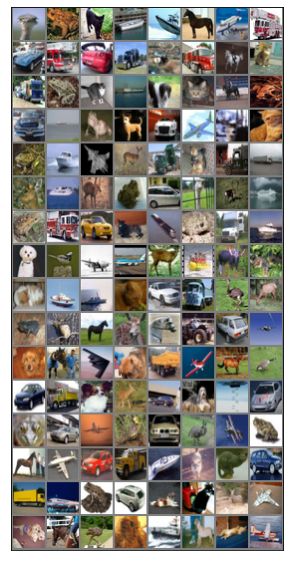

In [144]:
#!g1.1
%matplotlib inline

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15, 10))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
grid = (make_grid(real.cpu()) + 1) / 2
show(grid)

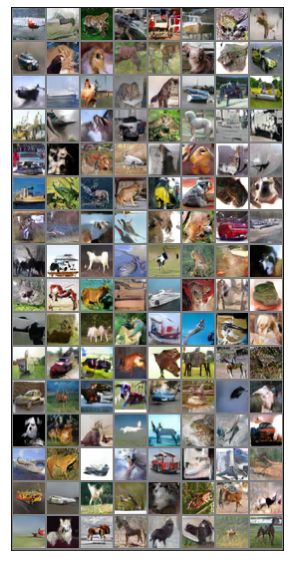

In [145]:
#!g1.1
grid = (make_grid(fake.cpu()) + 1) / 2
show(grid)

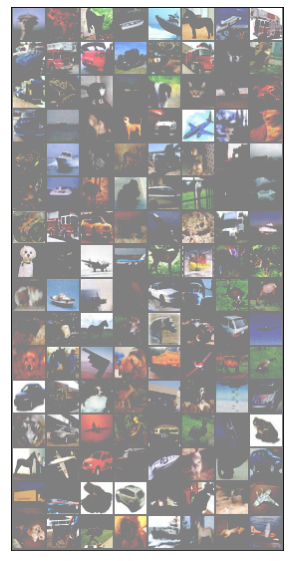

In [146]:
#!g1.1
grid = (make_grid(perturbed_real.cpu()) + 1) / 2
show(grid)

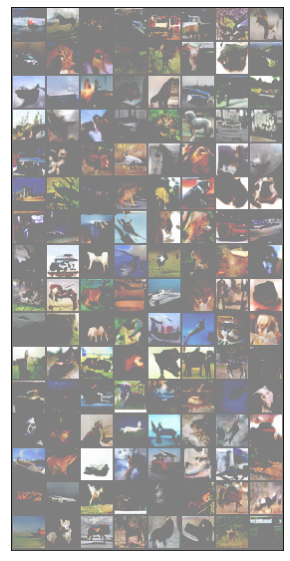

In [147]:
#!g1.1
grid = (make_grid(perturbed_fake.cpu()) + 1) / 2
show(grid)

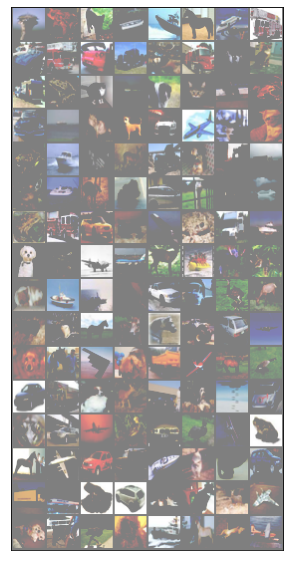

In [148]:
#!g1.1
grid = (make_grid(fgsm_attack(real, 0, real_grad).cpu()) + 1) / 2
show(grid)

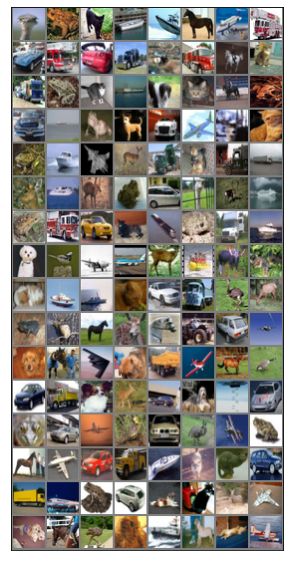

In [149]:
#!g1.1
#!g1.1
grid = (make_grid(real.cpu()) + 1) / 2
show(grid)

In [173]:
#!g1.1
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

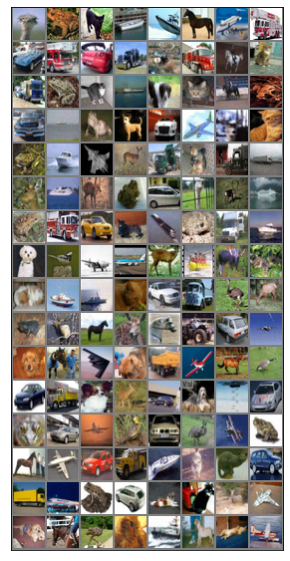

In [158]:
#!g1.1
grid = (make_grid(fgsm_attack(real, 0.02, real_grad).cpu()) + 1) / 2
show(grid)

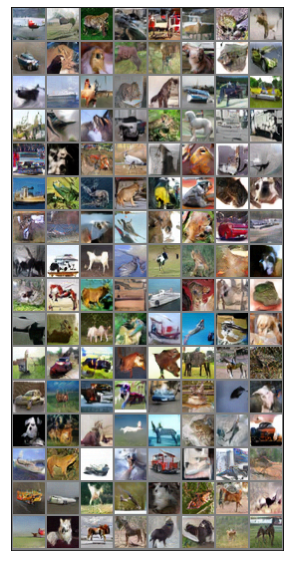

In [162]:
#!g1.1
grid = (make_grid(fgsm_attack(fake, 0.02, fake_grad).cpu()) + 1) / 2
show(grid)

In [168]:
#!g1.1
z = torch.randn(128 * 2, 100).to(device)
# FGSM G
fake = net_G(z).detach()
fake.requires_grad = True
net_D_fake = net_D(fake)
loss_G = loss_fn(net_D_fake)
net_D.zero_grad()
loss_G.backward()
fake_grad = fake.grad.data

In [166]:
#!g1.1
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(30, 20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

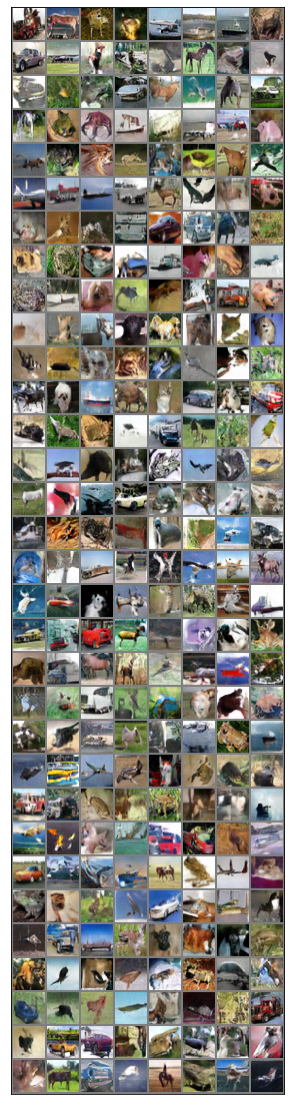

In [171]:
#!g1.1
perturbed_fake = fgsm_attack(fake, 0.02, fake_grad)
grid = (make_grid(perturbed_fake.cpu()) + 1) / 2
show(grid)

# Lessssgo


In [177]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)

num_epochs = 250
fgsm_chance = 0.2
epsilon = 0.02
start_fgsm_epoch = int(num_epochs * 0.1)

sample_z = torch.randn(64, 100).to(device)

Using device cuda:0


In [220]:
#!g1.1
def train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record):        
    if record:
        wandb.init(
        project="SNGAN_w_FGSM",
        config={
            "epochs": num_epochs,
            "batch_size": batch_size,
            "lr": lr,
            "betas": betas,
            "sheduler": "LambdaLR",
            "sheduler step": "1 - step / 100000",
            "sample step": 500,
            "FGSM epsilon": epsilon,
            "FGSM chance": fgsm_chance,
            "start FGSM epoch": start_fgsm_epoch
            })
        
        fake = net_G(sample_z).cpu()
        grid = (make_grid(fake) + 1) / 2
        real, _ = next(iter(dataloader))
        grid2 = (make_grid(real[:64]) + 1) / 2
        images = wandb.Image(grid2, caption="real")
        wandb.log({"samples": images})
        images = wandb.Image(grid, caption="before training")
        wandb.log({"samples": images})
        
    # Training Loop    
    print("Starting Training Loop...")
    start = time.time()
    for epoch in range(1, num_epochs + 1):
        # For each batch in the dataloader
        for i, data in enumerate(tqdm(dataloader, desc=f'Training {epoch}/{num_epochs}')):
            # Discriminator
            with torch.no_grad():
                z = torch.randn(128, 100).to(device)
                fake = net_G(z).detach()
            real = data[0].to(device)
            real.requires_grad = True
            net_D_real = net_D(real)
            fake.requires_grad = True
            net_D_fake = net_D(fake)
            loss_D = loss_fn(net_D_real, net_D_fake)
            
            if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                net_D.zero_grad()
                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()
                
                real_grad = real.grad.data
                perturbed_real = fgsm_attack(real, epsilon, real_grad)
                
                fake_grad = fake.grad.data
                perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
                
                net_D_real = net_D(perturbed_real)
                net_D_fake = net_D(perturbed_fake)
                loss_D = loss_fn(net_D_real, net_D_fake)

            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()
            
            # Generator
            z = torch.randn(128 * 2, 100).to(device)
            if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                fake = net_G(z).detach()
                fake.requires_grad = True
                net_D_fake = net_D(fake)
                loss_G = loss_fn(net_D_fake)
                net_D.zero_grad()
                optim_G.zero_grad()
                loss_G.backward()
                optim_G.step()
                fake_grad = fake.grad.data
                perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
                loss_G = loss_fn(net_D(perturbed_fake))
            else:
                loss_G = loss_fn(net_D(net_G(z)))if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                
#                 print(z.grad, 'z1')
#                 #fake.requires_grad = True
#                 # print(fake.requires_grad)
#                 loss_G = loss_fn(net_D_fake)
#                 print(loss_G.grad)
#                 net_D.zero_grad()
#                 optim_G.zero_grad()
#                 loss_G.backward(retain_graph=True)
#                 loss_G.retain_grad()
#                 print(z.grad, 'z2')
#                 print(loss_G.grad)
#                 optim_G.step()
#                 print(fake.grad)
                #fake_grad = fake.grad.data
                fake = net_G(z)
                net_D_fake = net_D(fake)
                loss_G = loss_fn(net_D_fake)
                fake_grad = torch.autograd.grad(loss_G, [fake])[0]
                perturbed_fake_G = fgsm_attack(fake, epsilon, fake_grad)
                loss_G = loss_fn(net_D(perturbed_fake_G))
            else:
#                 net_D_fake = net_D(fake)
                loss_G = loss_fn(net_D(net_G(z)))
                
            
            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

            sched_G.step()
            sched_D.step()
            
            if record:
                metrics = {"train/generator_loss": loss_G, 
                           "train/discriminator_loss": loss_D}
                wandb.log(metrics)
            
        print('loss_g = {:.3f}, loss_d = {:.3f}'.format(loss_G, loss_D))
        if record:
            fake = net_G(sample_z).detach()
            grid = (make_grid(fake.cpu()) + 1) / 2
            images = wandb.Image(grid, caption="after epoch {}".format(epoch))
            wandb.log({"samples": images})
            
            if epoch >= start_fgsm_epoch:
                # FGSM log
                grid = (make_grid(perturbed_real.cpu()) + 1) / 2
                images_real = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                grid = (make_grid(perturbed_fake.cpu()) + 1) / 2
                images_fake = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                grid = (make_grid(perturbed_fake_G.cpu()) + 1) / 2
                images_G = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                wandb.log({
                    "FGSM on real in D": images_real,
                    "FGSM on fake in D": images_fake,
                    "FGSM in G": images_G
                })
            
            imgs = generate_imgs(
                    net_G, device, 100,
                    50000, batch_size)
            IS, FID = get_inception_score_and_fid(
                imgs, 'cifar10.train.npz', verbose=True)
            is_fid_imgs = {"train/IS": IS[0],
                          "train/IS_std": IS[1],
                          "train/FID:": FID}
            wandb.log(is_fid_imgs)

        if epoch % 5 == 0:
            clear_output()
        
    print('Training for batch size = {}, epochs = {} done for {:.1f} hours'.format(batch_size, num_epochs, (time.time() - start) / 60 / 60))
    wandb.finish()

In [223]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=False)

In [225]:
#!g1.1
def train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record):        
    if record:
        wandb.init(
        project="SNGAN_w_FGSM",
        config={
            "epochs": num_epochs,
            "batch_size": batch_size,
            "lr": lr,
            "betas": betas,
            "sheduler": "LambdaLR",
            "sheduler step": "1 - step / 100000",
            "sample step": 500,
            "FGSM epsilon": epsilon,
            "FGSM chance": fgsm_chance,
            "start FGSM epoch": start_fgsm_epoch
            })
        
        fake = net_G(sample_z).cpu()
        grid = (make_grid(fake) + 1) / 2
        real, _ = next(iter(dataloader))
        grid2 = (make_grid(real[:64]) + 1) / 2
        images = wandb.Image(grid2, caption="real")
        wandb.log({"samples": images})
        images = wandb.Image(grid, caption="before training")
        wandb.log({"samples": images})
        
    # Training Loop    
    print("Starting Training Loop...")
    start = time.time()
    for epoch in range(1, num_epochs + 1):
        # For each batch in the dataloader
        for i, data in enumerate(tqdm(dataloader, desc=f'Training {epoch}/{num_epochs}')):
            # Discriminator
            with torch.no_grad():
                z = torch.randn(128, 100).to(device)
                fake = net_G(z).detach()
            real = data[0].to(device)
            real.requires_grad = True
            net_D_real = net_D(real)
            fake.requires_grad = True
            net_D_fake = net_D(fake)
            loss_D = loss_fn(net_D_real, net_D_fake)
            
            if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                net_D.zero_grad()
                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()
                
                real_grad = real.grad.data
                perturbed_real = fgsm_attack(real, epsilon, real_grad)
                
                fake_grad = fake.grad.data
                perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
                
                net_D_real = net_D(perturbed_real)
                net_D_fake = net_D(perturbed_fake)
                loss_D = loss_fn(net_D_real, net_D_fake)

            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()
            
            # Generator
            z = torch.randn(128 * 2, 100).to(device)
            if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                fake = net_G(z)
                net_D_fake = net_D(fake)
                loss_G = loss_fn(net_D_fake)
                fake_grad = torch.autograd.grad(loss_G, [fake])[0]
                perturbed_fake_G = fgsm_attack(fake, epsilon, fake_grad)
                loss_G = loss_fn(net_D(perturbed_fake_G))
            else:
                loss_G = loss_fn(net_D(net_G(z)))
                
            
            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

            sched_G.step()
            sched_D.step()
            
            if record:
                metrics = {"train/generator_loss": loss_G, 
                           "train/discriminator_loss": loss_D}
                wandb.log(metrics)
            
        print('loss_g = {:.3f}, loss_d = {:.3f}'.format(loss_G, loss_D))
        if record:
            fake = net_G(sample_z).detach()
            grid = (make_grid(fake.cpu()) + 1) / 2
            images = wandb.Image(grid, caption="after epoch {}".format(epoch))
            wandb.log({"samples": images})
            
            if epoch >= start_fgsm_epoch:
                # FGSM log
                grid = (make_grid(perturbed_real.cpu()) + 1) / 2
                images_real = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                grid = (make_grid(perturbed_fake.cpu()) + 1) / 2
                images_fake = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                grid = (make_grid(perturbed_fake_G.cpu()) + 1) / 2
                images_G = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                wandb.log({
                    "FGSM on real in D": images_real,
                    "FGSM on fake in D": images_fake,
                    "FGSM in G": images_G
                })
            
            imgs = generate_imgs(
                    net_G, device, 100,
                    50000, batch_size)
            IS, FID = get_inception_score_and_fid(
                imgs, 'cifar10.train.npz', verbose=True)
            is_fid_imgs = {"train/IS": IS[0],
                          "train/IS_std": IS[1],
                          "train/FID:": FID}
            wandb.log(is_fid_imgs)

        if epoch % 5 == 0:
            clear_output()
        
    print('Training for batch size = {}, epochs = {} done for {:.1f} hours'.format(batch_size, num_epochs, (time.time() - start) / 60 / 60))
    wandb.finish()

In [226]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)

num_epochs = 250
fgsm_chance = 0.2
epsilon = 0.02
start_fgsm_epoch = int(num_epochs * 0.1)

sample_z = torch.randn(64, 100).to(device)

Using device cuda:0


In [227]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True)

Training for batch size = 128, epochs = 250 done for 12.5 hours



train/FID:,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/IS,▁▄▆▇▆▇▇████▇█████▇██████████████████████
train/IS_std,▁▂▆▆▄▃▅▆▅▇▃▄▆▅▃▆▄▅▄▃▇▄▄▆█▅▅▅▃▅▄▆▆▇▄▃▆▂▄▅
train/discriminator_loss,▅▄▄▄▅▆▄▇▄▄▅▄▄▄▃▇▃▃▃▃▂▃▃▂▂▃▂▂▃▃▂▂▁▂▂▂▁▁█▁
train/generator_loss,▄▆▄▂▁▅▃▅▂▂▁▅▃▂▃▅▇▂▂▄▄▄▇█▃▃▄▄▄▃▆▄▅▄▇▄▅▄▄▄
train/FID:,20.32966
train/IS,7.55029
train/IS_std,0.10291
train/discriminator_loss,2.38209
train/generator_loss,0.71078


In [228]:
#!g1.1
def train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record, run_name=None):        
    if record:
        wandb.init(
        project="SNGAN_w_FGSM",
        config={
            "epochs": num_epochs,
            "batch_size": batch_size,
            "lr": lr,
            "betas": betas,
            "sheduler": "LambdaLR",
            "sheduler step": "1 - step / 100000",
            "sample step": 500,
            "FGSM epsilon": epsilon,
            "FGSM chance": fgsm_chance,
            "start FGSM epoch": start_fgsm_epoch
            })
        
        if run_name is not None:
            wandb.run.name = run_name
        
        fake = net_G(sample_z).cpu()
        grid = (make_grid(fake) + 1) / 2
        real, _ = next(iter(dataloader))
        grid2 = (make_grid(real[:64]) + 1) / 2
        images = wandb.Image(grid2, caption="real")
        wandb.log({"samples": images})
        images = wandb.Image(grid, caption="before training")
        wandb.log({"samples": images})
        
    # Training Loop    
    print("Starting Training Loop...")
    start = time.time()
    for epoch in range(1, num_epochs + 1):
        # For each batch in the dataloader
        for i, data in enumerate(tqdm(dataloader, desc=f'Training {epoch}/{num_epochs}')):
            # Discriminator
            with torch.no_grad():
                z = torch.randn(128, 100).to(device)
                fake = net_G(z).detach()
            real = data[0].to(device)
            real.requires_grad = True
            net_D_real = net_D(real)
            fake.requires_grad = True
            net_D_fake = net_D(fake)
            loss_D = loss_fn(net_D_real, net_D_fake)
            
            if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                net_D.zero_grad()
                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()
                
                real_grad = real.grad.data
                perturbed_real = fgsm_attack(real, epsilon, real_grad)
                
                fake_grad = fake.grad.data
                perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
                
                net_D_real = net_D(perturbed_real)
                net_D_fake = net_D(perturbed_fake)
                loss_D = loss_fn(net_D_real, net_D_fake)

            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()
            
            # Generator
            z = torch.randn(128 * 2, 100).to(device)
            if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                fake = net_G(z)
                net_D_fake = net_D(fake)
                loss_G = loss_fn(net_D_fake)
                fake_grad = torch.autograd.grad(loss_G, [fake])[0]
                perturbed_fake_G = fgsm_attack(fake, epsilon, fake_grad)
                loss_G = loss_fn(net_D(perturbed_fake_G))
            else:
                loss_G = loss_fn(net_D(net_G(z)))
                
            
            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

            sched_G.step()
            sched_D.step()
            
            if record:
                metrics = {"train/generator_loss": loss_G, 
                           "train/discriminator_loss": loss_D}
                wandb.log(metrics)
            
        print('loss_g = {:.3f}, loss_d = {:.3f}'.format(loss_G, loss_D))
        if record:
            fake = net_G(sample_z).detach()
            grid = (make_grid(fake.cpu()) + 1) / 2
            images = wandb.Image(grid, caption="after epoch {}".format(epoch))
            wandb.log({"samples": images})
            
            if epoch >= start_fgsm_epoch:
                # FGSM log
                grid = (make_grid(perturbed_real.cpu()) + 1) / 2
                images_real = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                grid = (make_grid(perturbed_fake.cpu()) + 1) / 2
                images_fake = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                grid = (make_grid(perturbed_fake_G.cpu()) + 1) / 2
                images_G = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                wandb.log({
                    "FGSM on real in D": images_real,
                    "FGSM on fake in D": images_fake,
                    "FGSM in G": images_G
                })
            
            imgs = generate_imgs(
                    net_G, device, 100,
                    50000, batch_size)
            IS, FID = get_inception_score_and_fid(
                imgs, 'cifar10.train.npz', verbose=True)
            is_fid_imgs = {"train/IS": IS[0],
                          "train/IS_std": IS[1],
                          "train/FID:": FID}
            wandb.log(is_fid_imgs)

        if epoch % 5 == 0:
            clear_output()
        
    print('Training for batch size = {}, epochs = {} done for {:.1f} hours'.format(batch_size, num_epochs, (time.time() - start) / 60 / 60))
    wandb.finish()

In [229]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)

num_epochs = 250
fgsm_chance = 0.4
epsilon = 0.02
start_fgsm_epoch = int(num_epochs * 0.1)

sample_z = torch.randn(64, 100).to(device)

Using device cuda:0


In [230]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True, run_name="FGSM-chance-0.4")

Training for batch size = 128, epochs = 250 done for 13.2 hours



train/FID:,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/IS,▁▄▆▇▇▇▇▇█▇▇█████████████████████████████
train/IS_std,▁▃▆▇▃▃▄▄▆▄▅▆▅▃▅▆▅▅▇▄▅▅▅▄▅▅▅▅▅▅▄▅▆▅▄▅█▆▆▇
train/discriminator_loss,▆▅▅▅▅█▅█▄▄▅█▆▄▄▆▇▃▃▃▂▄▃▂▃▄▃▂█▂▂▂▆▂▂▁▁▇▆▇
train/generator_loss,▃▆▄▁▆▄▂▄▂▂▅▆▄▂▄▅█▄▃▂▅▅▇▇▅█▃▆▄▄█▅█▄▆▄▇█▇▇
train/FID:,23.02548
train/IS,7.28618
train/IS_std,0.10196
train/discriminator_loss,2.00191
train/generator_loss,0.78696


In [232]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)

num_epochs = 250
fgsm_chance = 0.6
epsilon = 0.02
start_fgsm_epoch = int(num_epochs * 0.1)

sample_z = torch.randn(64, 100).to(device)

Using device cuda:0


In [233]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True, run_name="FGSM-chance-0.6")

Training for batch size = 128, epochs = 250 done for 13.8 hours



train/FID:,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/IS,▁▄▆▇▇▇▇████▇████████████████████████▇▇▇▇
train/IS_std,▁▂▆▇▃▄▄▄▆▆▆▄▄▄▅█▄▄▆▃▆▇▃▆█▆▆▄▆▇▆▅▆▄▅▅▇▇▄▅
train/discriminator_loss,▇▆▆▆▆█▆█▅▅▆▇▇▅▄▇▇▃▂▃▆▄▃▂▃▃▃▆▆▂▂▁▄▁▂▁▁▆▄▅
train/generator_loss,▃▆▄▁▇▄▂▅▃▅▄▅▅▂▆▄▆█▅▇▆▃▆▇▅█▆▆▅▄▇▃█▄▆▆▆▇▆▇
train/FID:,31.96178
train/IS,6.79491
train/IS_std,0.08786
train/discriminator_loss,1.55093
train/generator_loss,0.84089


In [234]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)

num_epochs = 250
fgsm_chance = 0.8
epsilon = 0.02
start_fgsm_epoch = int(num_epochs * 0.1)

sample_z = torch.randn(64, 100).to(device)

Using device cuda:0


In [235]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True, run_name="FGSM-chance-0.8")

Training for batch size = 128, epochs = 250 done for 14.6 hours



train/FID:,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂
train/IS,▁▄▆▇▇▇▇▇█▇█▇█████▇██▇█▇▇▇▇▇▇▇▇▆▇▇▆▆▆▆▆▅▅
train/IS_std,▁▃▇█▄▃▇▅▅▄▆▇▄▇▄▅█▅█▇▄▄▅▆▇▆▃▃▅▃▅▅▄▅▅▄▃▅▄▆
train/discriminator_loss,▇▆▆▆█▇▇█▆▇█▇▆▅▆▆▆▄▄▆▅▆▆▅▅▆▄▄▄▅▅▄▄▁▂▁▃▃▃▃
train/generator_loss,▄▇▄▁▇▄▇▆▆▇▆▆▇▆█▇█▄▅█▇▇▇█▇▇▇▇▇▅▇▇▇▅▇▇▇▇▇▇
train/FID:,60.45478
train/IS,5.45716
train/IS_std,0.09246
train/discriminator_loss,1.14733
train/generator_loss,0.84514


In [236]:
#!g1.1
!python3 Training_SNGAN_with_FGSM.py

wandb: Currently logged in as: messlav (use `wandb login --relogin` to force relogin)
Files already downloaded and verified
Using device cuda:0
wandb: wandb version 0.12.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.12.11
wandb: Run data is saved locally in /home/jupyter/work/resources/wandb/run-20220410_132322-1rd669pj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run peach-armadillo-40
wandb: ⭐️ View project at https://wandb.ai/messlav/SNGAN_w_FGSM
wandb: 🚀 View run at https://wandb.ai/messlav/SNGAN_w_FGSM/runs/1rd669pj


^C





























Exception: Process exited with code -1

In [237]:
#!g1.1
wandb.finish()

In [255]:
#!g1.1
def train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record, run_name=None):        
    if record:
        wandb.init(
        project="SNGAN_w_FGSM",
        config={
            "epochs": num_epochs,
            "batch_size": batch_size,
            "lr": lr,
            "betas": betas,
            "sheduler": "LambdaLR",
            "sheduler step": "1 - step / 100000",
            "sample step": 500,
            "FGSM epsilon": epsilon,
            "FGSM chance": fgsm_chance,
            "start FGSM epoch": start_fgsm_epoch
            })
        
        if run_name is not None:
            wandb.run.name = run_name
        
        fake = net_G(sample_z).cpu()
        grid = (make_grid(fake) + 1) / 2
        real, _ = next(iter(dataloader))
        grid2 = (make_grid(real[:64]) + 1) / 2
        images = wandb.Image(grid2, caption="real")
        wandb.log({"samples": images})
        images = wandb.Image(grid, caption="before training")
        wandb.log({"samples": images})
        
    # Training Loop    
    print("Starting Training Loop...")
    start = time.time()
    for epoch in range(1, num_epochs + 1):
        # For each batch in the dataloader
        for i, data in enumerate(tqdm(dataloader, desc=f'Training {epoch}/{num_epochs}')):
            # Discriminator
            with torch.no_grad():
                z = torch.randn(128, 100).to(device)
                fake = net_G(z).detach()
            real = data[0].to(device)
            real.requires_grad = True
            fake.requires_grad = True
            net_D_real = net_D(real)
            net_D_fake = net_D(fake)
            loss_D = loss_fn(net_D_real, net_D_fake)
            if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                real_grad = torch.autograd.grad(loss_D, [real])[0]
                fake_grad = torch.autograd.grad(loss_D, [fake])[0]
                perturbed_real = fgsm_attack(real, epsilon, real_grad)
                perturbed_fake = fgsm_attack(fake, epsilon, fake_grad)
                net_D_real = net_D(perturbed_real)
                net_D_fake = net_D(perturbed_fake)
                loss_D = loss_fn(net_D_real, net_D_fake)
            
            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()
            
            # Generator
            z = torch.randn(128 * 2, 100).to(device)
            if epoch >= start_fgsm_epoch and np.random.random() < fgsm_chance:
                # FGSM
                fake = net_G(z)
                net_D_fake = net_D(fake)
                loss_G = loss_fn(net_D_fake)
                fake_grad = torch.autograd.grad(loss_G, [fake])[0]
                perturbed_fake_G = fgsm_attack(fake, epsilon, fake_grad)
                loss_G = loss_fn(net_D(perturbed_fake_G))
            else:
                loss_G = loss_fn(net_D(net_G(z)))
                
            
            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

            sched_G.step()
            sched_D.step()
            
            if record:
                metrics = {"train/generator_loss": loss_G, 
                           "train/discriminator_loss": loss_D}
                wandb.log(metrics)
            
        print('loss_g = {:.3f}, loss_d = {:.3f}'.format(loss_G, loss_D))
        if record:
            fake = net_G(sample_z).detach()
            grid = (make_grid(fake.cpu()) + 1) / 2
            images = wandb.Image(grid, caption="after epoch {}".format(epoch))
            wandb.log({"samples": images})
            
            if epoch >= start_fgsm_epoch:
                # FGSM log
                grid = (make_grid(perturbed_real.cpu()) + 1) / 2
                images_real = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                grid = (make_grid(perturbed_fake.cpu()) + 1) / 2
                images_fake = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                grid = (make_grid(perturbed_fake_G.cpu()) + 1) / 2
                images_G = wandb.Image(grid, caption="last in epoch {}".format(epoch))
                
                wandb.log({
                    "FGSM on real in D": images_real,
                    "FGSM on fake in D": images_fake,
                    "FGSM in G": images_G
                })
            
            imgs = generate_imgs(
                    net_G, device, 100,
                    50000, batch_size)
            IS, FID = get_inception_score_and_fid(
                imgs, 'cifar10.train.npz', verbose=True)
            is_fid_imgs = {"train/IS": IS[0],
                          "train/IS_std": IS[1],
                          "train/FID:": FID}
            wandb.log(is_fid_imgs)

        if epoch % 5 == 0:
            clear_output()
        
    print('Training for batch size = {}, epochs = {} done for {:.1f} hours'.format(batch_size, num_epochs, (time.time() - start) / 60 / 60))
    wandb.finish()

In [256]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)

num_epochs = 250
fgsm_chance = 0.2
epsilon = 0.02
start_fgsm_epoch = int(num_epochs * 0.1)

sample_z = torch.randn(64, 100).to(device)

Using device cuda:0


In [257]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True,
                 run_name="updated-D-FGSM-chance-0.2")

Training for batch size = 128, epochs = 250 done for 12.5 hours



train/FID:,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/IS,▁▄▆▇▇▇▇▇██▇██████▇██████████████████████
train/IS_std,▁▃▇█▅▆▅▆▆▃▅█▄▅▇▃▃▅█▅▄▆▆▆▆▇▅▅█▇▆▇▆▅▆▆▇▆▇▅
train/discriminator_loss,▄▄▄▄▄█▄▇▄▄▄▃▃▄▃█▃▄▂▂▃▃▂▂▂▃▂▂▂▂▂▂▁▁▂▁▁▁█▁
train/generator_loss,▅█▆▂▅▅▇▆▄▄▄▅▆▄▁▆▆▁▂▅▄▆▅█▄▆▄▆▅▃▇▅▅▆█▅▆▅▆▆
train/FID:,19.74027
train/IS,7.53074
train/IS_std,0.09162
train/discriminator_loss,2.33186
train/generator_loss,0.68218


In [258]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)

num_epochs = 250
fgsm_chance = 0.4
epsilon = 0.02
start_fgsm_epoch = int(num_epochs * 0.1)

sample_z = torch.randn(64, 100).to(device)

Using device cuda:0


In [259]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True,
                 run_name="updated-D-FGSM-chance-0.4")

Training for batch size = 128, epochs = 250 done for 13.2 hours



train/FID:,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/IS,▁▄▆▇▆▇▇▇█▇▇▇█████▇██████████████████████
train/IS_std,▁▃▆▇▄▃▇▂▅▅▅▆▅▆▆▄▅▅▆▅▃▆▄▃▆█▇▅▅▆▇▄▂▃▅▇▇▆▃▃
train/discriminator_loss,▅▄▄▄▆█▅█▅▅▅█▇▅▄██▃▂▃▂▃▃▂▃▃▃▂▇▃▂▂▆▁▂▁▁▆▆▆
train/generator_loss,▄█▅▁▄▅▄▅▄▃▄▆▆▄▇▅▇▆▄▆▇▆▆█▇▇▅▇▅▄▆▅█▅▇▅▇███
train/FID:,23.50389
train/IS,7.26938
train/IS_std,0.04763
train/discriminator_loss,1.98639
train/generator_loss,0.79009


In [260]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)

num_epochs = 250
fgsm_chance = 0.6
epsilon = 0.02
start_fgsm_epoch = int(num_epochs * 0.1)

sample_z = torch.randn(64, 100).to(device)

Using device cuda:0


In [261]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True,
                 run_name="updated-D-FGSM-chance-0.6")

Training for batch size = 128, epochs = 250 done for 13.8 hours



train/FID:,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/IS,▁▄▇█▇███████████████████████████████████
train/IS_std,▁▃▇█▆▆▅█▅▆▆▅▅█▆▂▅▇▅▄▆▄▅▃▅▅▆▄▄▄▆▅▅▆▄▇▅▆▅▃
train/discriminator_loss,▃▁▁▁████████████████████████████████████
train/generator_loss,▅█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/FID:,45.60716
train/IS,6.49129
train/IS_std,0.07969
train/discriminator_loss,2.0
train/generator_loss,-0.23717


In [ ]:
#!g1.1
set_random_seed(3407)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

net_G = Generator(100).to(device)
net_D = Discriminator().to(device)

loss_fn = Hinge()

lr = 0.0002
betas = [0.0, 0.9]
optim_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=betas)
optim_D = torch.optim.Adam(net_D.parameters(), lr=lr, betas=betas)
sched_G = torch.optim.lr_scheduler.LambdaLR(
    optim_G, lambda step: 1 - step / 100000)
sched_D = torch.optim.lr_scheduler.LambdaLR(
    optim_D, lambda step: 1 - step / 100000)

num_epochs = 250
fgsm_chance = 0.8
epsilon = 0.02
start_fgsm_epoch = int(num_epochs * 0.1)

sample_z = torch.randn(64, 100).to(device)

Using device cuda:0


In [ ]:
#!g1.1
train_gan_w_fgsm(dataloader, net_D, net_G, num_epochs, loss_fn, optim_G, optim_D, sched_G, sched_D, record=True,
                 run_name="updated-D-FGSM-chance-0.8")